# Imports

In [ ]:
import csv
import itertools
import os
import random
import re
import zipfile

from subprocess import check_output

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import skimage as ski
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from numpy import array
from PIL import Image, ImageFilter
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn import svm
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-05-21 14:54:15.277412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 14:54:15.277539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 14:54:15.406664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [ ]:
zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


# Reading and Exploring the data

In [ ]:
TRAIN_DIR_PATH = './train'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [ ]:
TRAIN_DIR_PATH = './test1'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 12500 number of images in directory.


In [ ]:
IMAGE_FOLDER_PATH = "../working/train"
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)

In [ ]:
targets = list()
full_paths = list()
train_cats_dir = list()
train_dogs_dir = list()

# finding each file's target
for file_name in FILE_NAMES:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)

    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)

    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame() # make dataframe
dataset['image_path'] = full_paths # file path
dataset['target'] = targets # file's target

In [ ]:
train_cats_dir[:5]


['../working/train/cat.4804.jpg',
 '../working/train/cat.4991.jpg',
 '../working/train/cat.6631.jpg',
 '../working/train/cat.4955.jpg',
 '../working/train/cat.8310.jpg']

In [ ]:
train_dogs_dir[:5]

['../working/train/dog.7889.jpg',
 '../working/train/dog.11452.jpg',
 '../working/train/dog.2475.jpg',
 '../working/train/dog.9164.jpg',
 '../working/train/dog.8594.jpg']

In [ ]:
dataset.head()

,image_path,target
0,../working/train/dog.7889.jpg,dog
1,../working/train/dog.11452.jpg,dog
2,../working/train/cat.4804.jpg,cat
3,../working/train/cat.4991.jpg,cat
4,../working/train/cat.6631.jpg,cat


In [ ]:
len(dataset)

25000

In [ ]:
print("total data counts:", dataset['target'].count())
counts = dataset['target'].value_counts()
print(counts)

total data counts: 25000
target
dog    12500
cat    12500
Name: count, dtype: int64


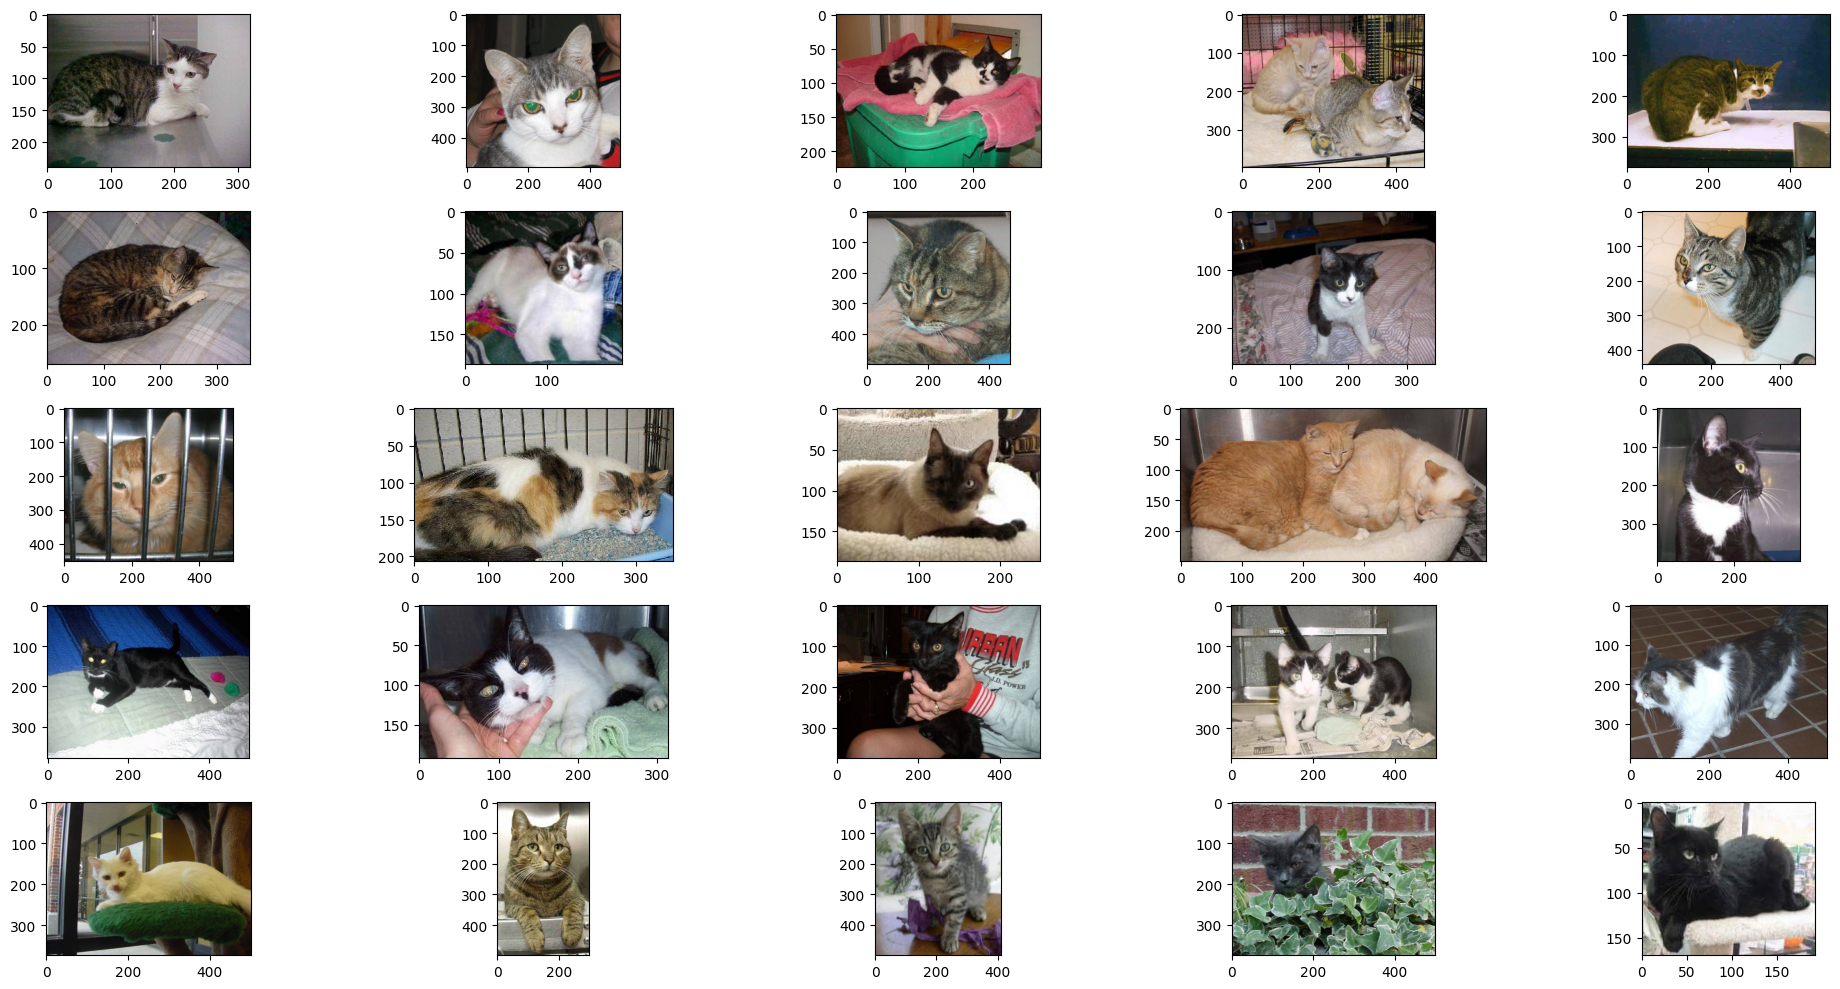

In [ ]:
rows = 5
cols = 5
axes = []
fig=plt.figure(figsize=(20,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_cats_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1

fig.tight_layout()
plt.show()

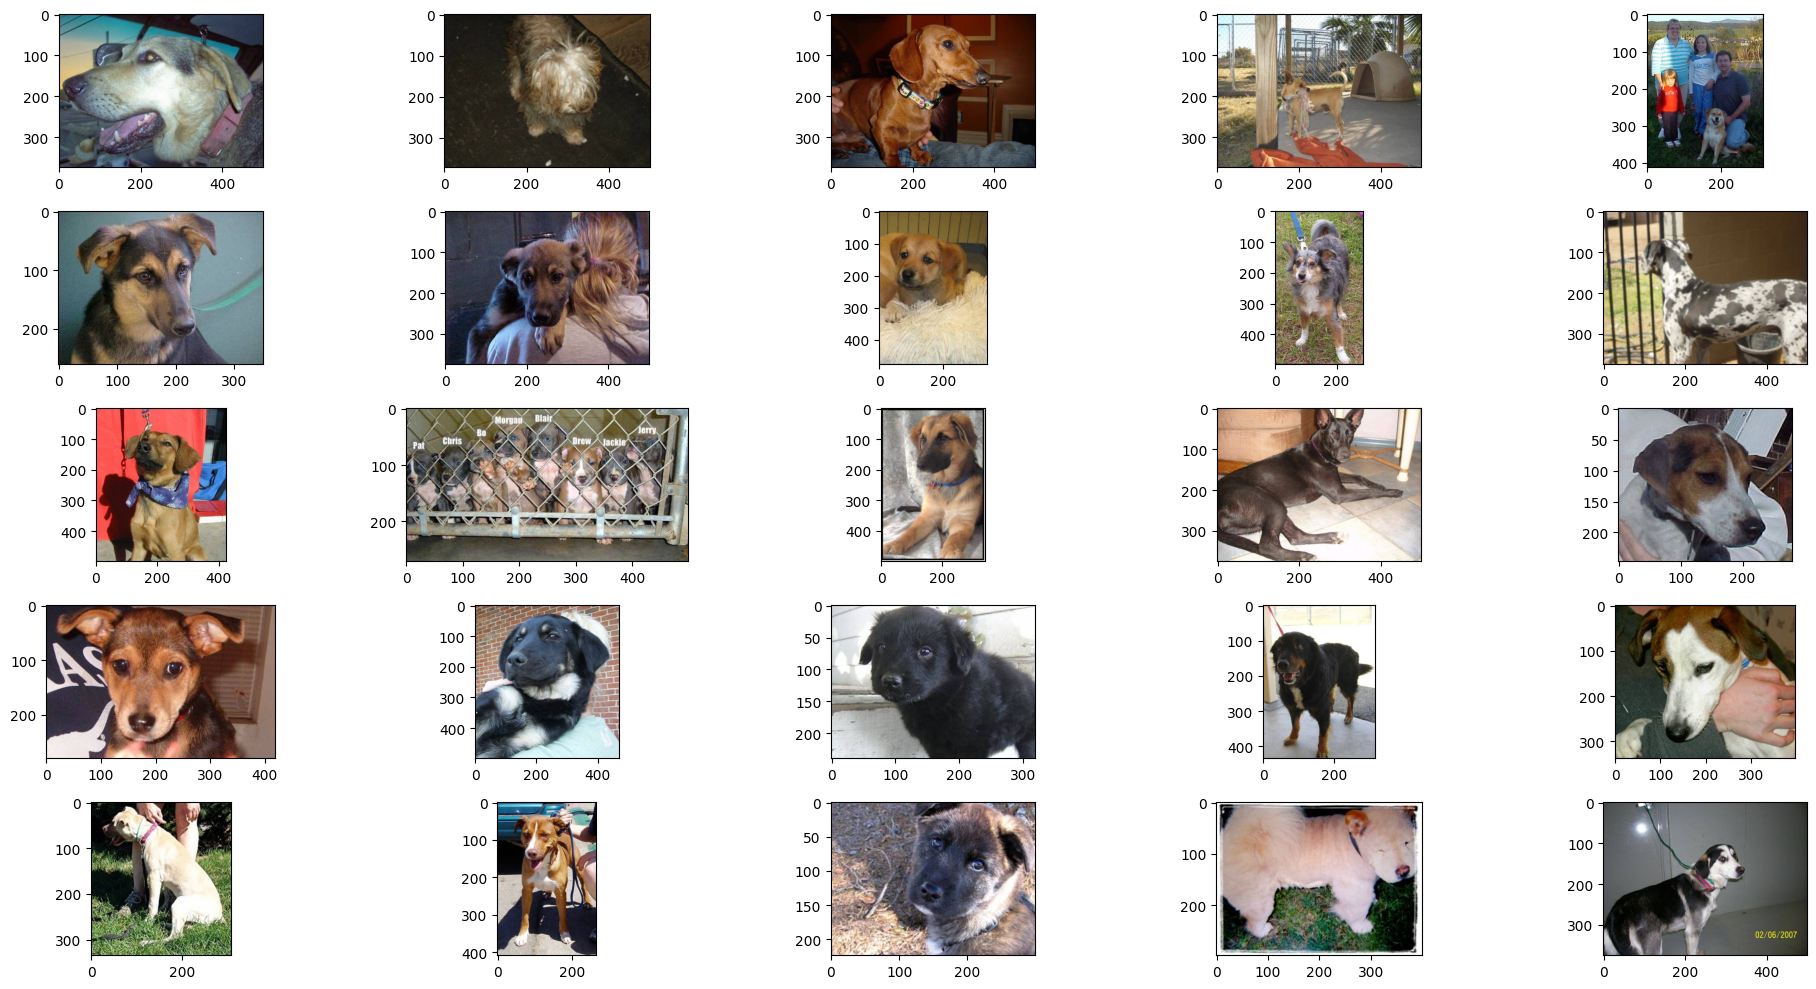

In [ ]:
rows = 5
cols = 5
axes = []
fig=plt.figure(figsize=(20,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_dogs_dir[i])
    axes.append(fig.add_subplot(rows,cols,a+1))
    plt.imshow(b)
    i+=1

fig.tight_layout()
plt.show()

In [ ]:
train, test_val = train_test_split(dataset, test_size=0.2, stratify=dataset['target'], random_state=20)
test, val = train_test_split(test_val, test_size=0.5,  stratify=test_val['target'], random_state=20)

In [ ]:
train.shape, test_val.shape

((20000, 2), (5000, 2))

In [ ]:
target_distribution =test['target'].value_counts()
target_distribution.head(10)

target
cat    1250
dog    1250
Name: count, dtype: int64

In [ ]:
TEST_DIR = 'test1/'
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)] # use this for test images

In [ ]:
dataset

,image_path,target
0,../working/train/dog.7889.jpg,dog
1,../working/train/dog.11452.jpg,dog
2,../working/train/cat.4804.jpg,cat
3,../working/train/cat.4991.jpg,cat
4,../working/train/cat.6631.jpg,cat
...,...,...
24995,../working/train/cat.256.jpg,cat
24996,../working/train/cat.6455.jpg,cat
24997,../working/train/cat.2225.jpg,cat
24998,../working/train/dog.10609.jpg,dog


In [ ]:
# dataset=dataset[:10]
# test_images=test_images[:10]
# dataset

# Train and Evaluation

In [ ]:
def preprocess_image(image_path):
    img = imread(image_path)
    # Resize the image to a fixed size
    img = resize(img, (128, 128))
    # Flatten the image to a 1D array
    img_flat = img.flatten()
    return img_flat

X = []
y = dataset['target']
for image_path in dataset['image_path']:
    X.append(preprocess_image(image_path))
X = np.array(X)

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='rbf')

clf.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = clf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6778


# The Result

In [ ]:
X_test = []
for image_path in test_images:
    img = preprocess_image(image_path)
    X_test.append(img)
X_test = np.array(X_test)

X_test_pca = pca.transform(X_test)

In [ ]:
test_predictions = clf.predict(X_test_pca)

test_predictions_mapped = [1 if label == 'dog' else 0 for label in test_predictions]

predictions_df = pd.DataFrame({'id': range(1, len(test_predictions_mapped) + 1), 'label': test_predictions_mapped})

predictions_df.to_csv('svm_test_predictions.csv', index=False)

predictions_df

,id,label
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
12495,12496,1
12496,12497,1
12497,12498,0
12498,12499,1
